In [1]:
#importo e librerie che mi serviranno
import pymongo
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import json

URI = "mongodb://127.0.0.1:27017/?readPreference=primary&ssl=false"
client = pymongo.MongoClient(URI)
db = client['movie_dataset']

In [2]:
#cerco chi sono gli utenti che hanno votato di più
df= pd.DataFrame( db.ratings.aggregate([{'$group': {'_id': '$userId','total': {'$sum': 1}}},{'$sort':{'total': -1}},{'$limit': 10}
]))
df.head()

,_id,total
0,45811,18276
1,8659,9279
2,270123,7638
3,179792,7515
4,228291,7410


In [3]:
#una volta trovati prelevo le loro votazioni dalla collezione rating
df_ratings = pd.DataFrame(db.ratings.find({"$or": [{'userId':45811},{'userId':8659},{'userId':270123}, {'userId':179792}, {'userId':228291}, {'userId':243443}, {'userId':98415}, {'userId':229879}, {'userId':98787}, {'userId':172224}]}))
df_ratings.head()


,_id,userId,movieId,rating,timestamp
0,5f662fdf1d75e6a75f7b4119,8659,1,4.0,997044423
1,5f662fdf1d75e6a75f7b411a,8659,2,4.0,997144402
2,5f662fdf1d75e6a75f7b411b,8659,3,3.0,997144734
3,5f662fdf1d75e6a75f7b411c,8659,4,3.0,997146175
4,5f662fdf1d75e6a75f7b411d,8659,5,3.0,997145617


In [4]:
df_ratings.userId.value_counts()

45811     18276
8659       9279
270123     7638
179792     7515
228291     7410
243443     6320
98415      6094
229879     6024
98787      5814
172224     5701
Name: userId, dtype: int64

In [5]:
#elimino colonna _id
df_ratings.drop("_id",axis='columns', inplace=True)
df_ratings.sample(5)

,userId,movieId,rating,timestamp
28471,98415,2177,2.5,1200630772
48681,179792,5042,1.0,1171888702
50660,179792,8662,3.0,1191291771
48741,179792,5135,4.0,1169861691
38034,98787,87483,0.5,1466837065


In [6]:
#lista dei film, nella collezione metadata
df_film = pd.DataFrame(db.metadata.find({}, {'_id':1, 'genres':1}))
df_film

,_id,genres
0,862,"[16, 35, 10751]"
1,8844,"[12, 14, 10751]"
2,15602,"[10749, 35]"
3,31357,"[35, 18, 10749]"
4,11862,[35]
...,...,...
45428,439050,"[18, 10751]"
45429,111109,[18]
45430,67758,"[28, 18, 53]"
45431,227506,[]


In [7]:
#rinomino la colonna _id in movie_id
df_film =  df_film.rename(columns = {'_id' : 'movieId'})

In [8]:
#converto i vari id del dataframe da oggetti a int
df_film.movieId = df_film.movieId.astype(str).astype(int)

In [9]:
#utilizzo funzione explode, per creare nuove righe dagli elementi dell' array presenti nella colonna genres
df_film = df_film.explode('genres')
df_film.explode('genres')
df_film = df_film.drop_duplicates(subset ="movieId") 
  


In [10]:
df_film.head()

,movieId,genres
0,862,16
1,8844,12
2,15602,10749
3,31357,35
4,11862,35


In [11]:
#vedo quanti na ci sono 
df_film.isna().sum()

movieId       0
genres     2442
dtype: int64

In [12]:
#prendo solo le righe dove non ci sono na
df_film = df_film[df_film['genres'].notna()]


In [13]:
#check per controllare se ci sono ancora na
df_film.isna().sum()

movieId    0
genres     0
dtype: int64

In [14]:
df_film.shape

(42991, 2)

In [15]:
#prendo i generi nella collezione genres
df_genres = pd.DataFrame(db.genres.find({}))
df_genres.head()

,_id,name
0,16,Animation
1,35,Comedy
2,10751,Family
3,12,Adventure
4,14,Fantasy


In [16]:
#rinomino la colonna _id in movie_id
df_genres =  df_genres.rename(columns = {'_id' : 'genres'})

In [17]:
df_genres.head(2)

,genres,name
0,16,Animation
1,35,Comedy


In [18]:
#join con il dataframe contenente i vari id dei film
df_merge = pd.merge(df_genres, df_film, on='genres')
df_merge.head(2)

,genres,name,movieId
0,16,Animation,862
1,16,Animation,22586


In [19]:
df_merge.shape

(42991, 3)

In [20]:
#join con il dataframe contenente i 5 utenti scelti dalla collezione ratings
df_secondmerge = pd.merge(df_ratings, df_merge, on='movieId')
df_secondmerge

,userId,movieId,rating,timestamp,genres,name
0,8659,2,4.0,997144402,18,Drama
1,45811,2,3.0,1473241811,18,Drama
2,98415,2,3.0,1025857792,18,Drama
3,98787,2,3.5,1467005014,18,Drama
4,172224,2,4.0,966422244,18,Drama
...,...,...,...,...,...,...
21856,270123,144560,3.0,1452324249,10749,Romance
21857,270123,145162,1.0,1498259026,80,Crime
21858,270123,151509,3.0,1453527817,35,Comedy
21859,270123,159109,1.5,1465361347,35,Comedy


In [21]:
prova = df_secondmerge.groupby(['userId', 'name']).count()
prova.reset_index(inplace=True)
prova = prova.drop(['movieId','rating','genres'], axis=1)
prova =  prova.rename(columns = {'timestamp' : 'count'})


In [22]:
k = prova.groupby('userId')['count'].sum().reset_index()
k =  k.rename(columns = {'count' : 'sum'})

In [23]:
#VEDO PER OGNI UTENTE QUANTI VOLTE HA VOTATO PER OGNI GENERE E IN TOTALE
df_H = pd.merge(k, prova, on='userId')
df_H

,userId,sum,name,count
0,8659,3002,Action,386
1,8659,3002,Adventure,177
2,8659,3002,Animation,50
3,8659,3002,Comedy,578
4,8659,3002,Crime,169
...,...,...,...,...
195,270123,2008,Science Fiction,40
196,270123,2008,TV Movie,10
197,270123,2008,Thriller,70
198,270123,2008,War,17


In [24]:
#CALCOLO LA PERCENTUALE
df_H['Percentage'] = (df_H['count']/df_H['sum'])*100
df_H['Percentage'] =  df_H['Percentage'].round(decimals=2)

In [25]:
df_H

,userId,sum,name,count,Percentage
0,8659,3002,Action,386,12.86
1,8659,3002,Adventure,177,5.90
2,8659,3002,Animation,50,1.67
3,8659,3002,Comedy,578,19.25
4,8659,3002,Crime,169,5.63
...,...,...,...,...,...
195,270123,2008,Science Fiction,40,1.99
196,270123,2008,TV Movie,10,0.50
197,270123,2008,Thriller,70,3.49
198,270123,2008,War,17,0.85


In [26]:
s = df_H.userId.unique()

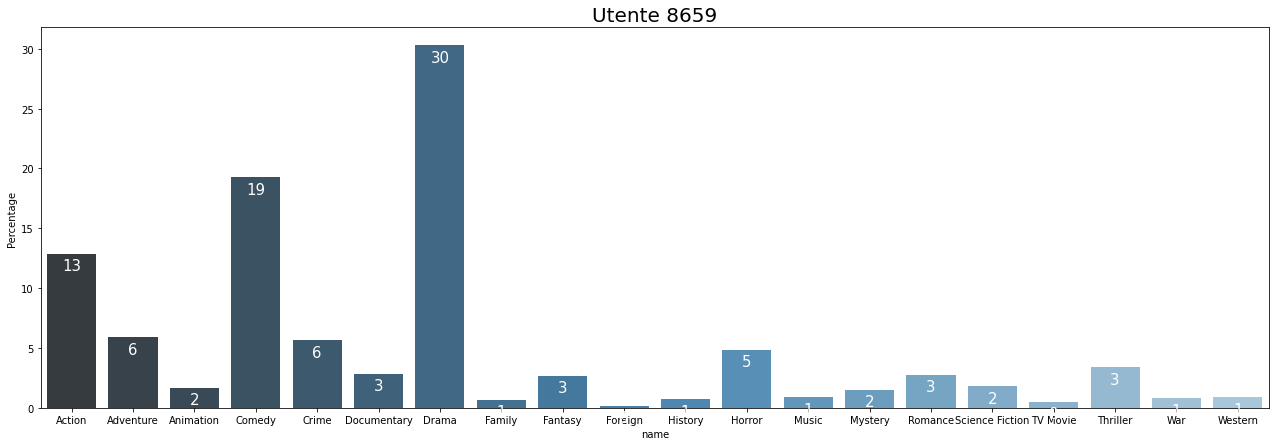

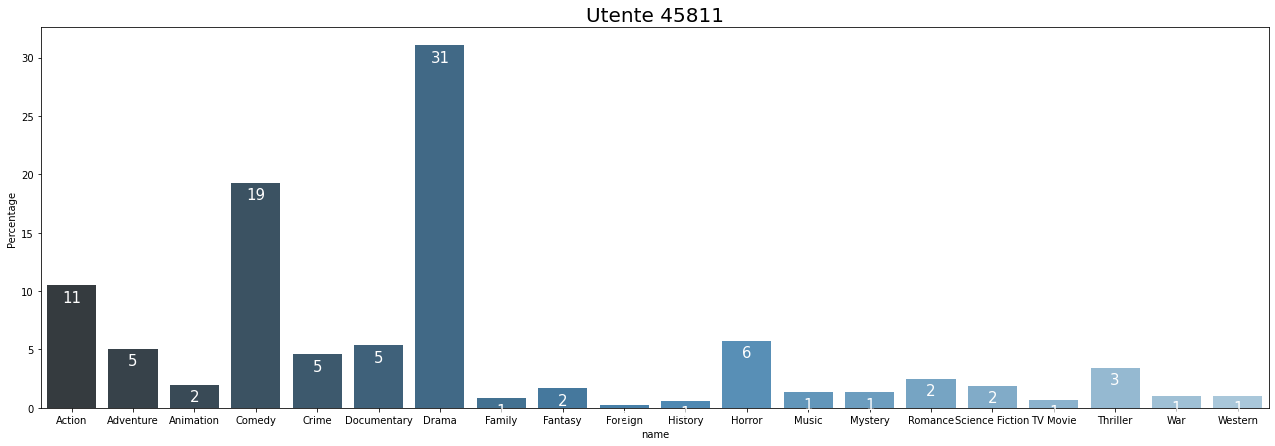

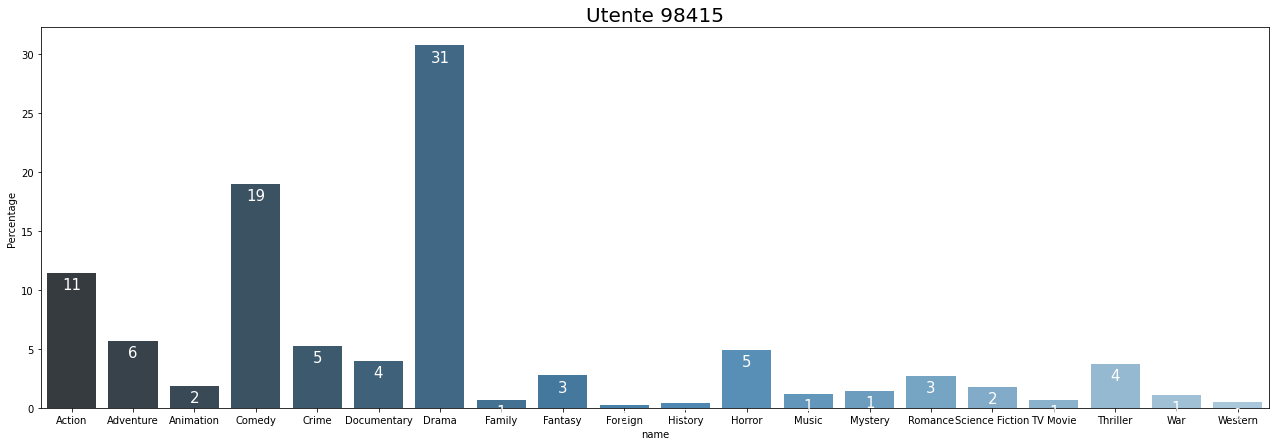

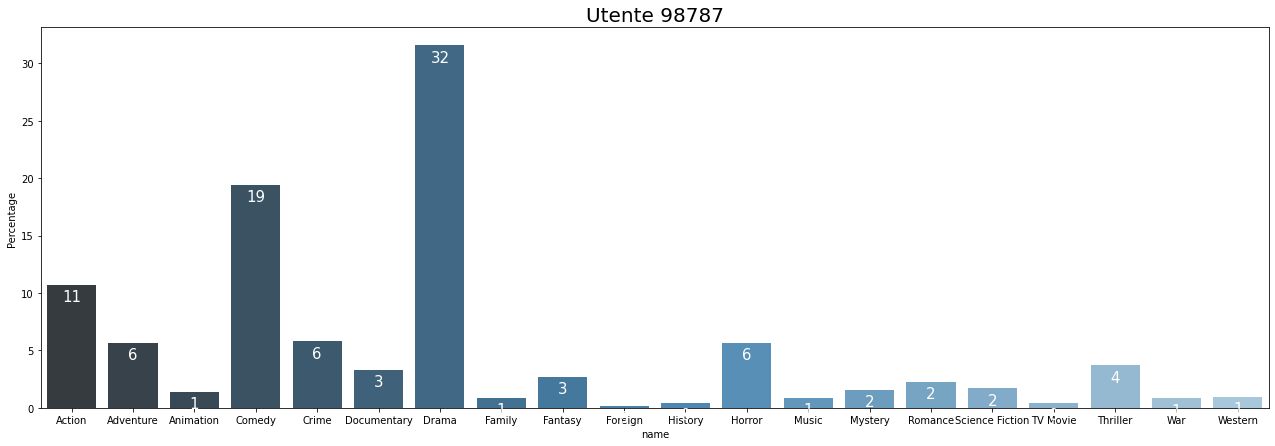

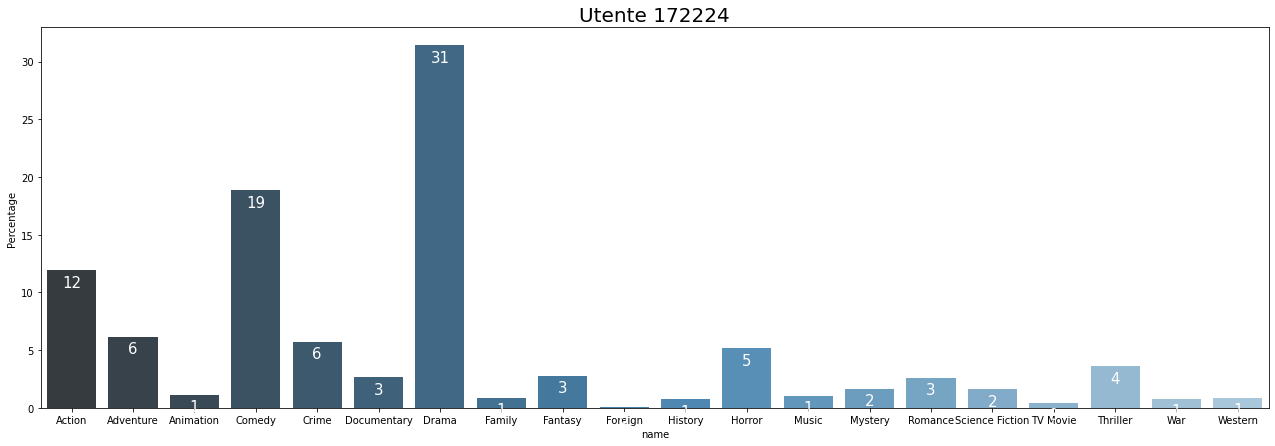

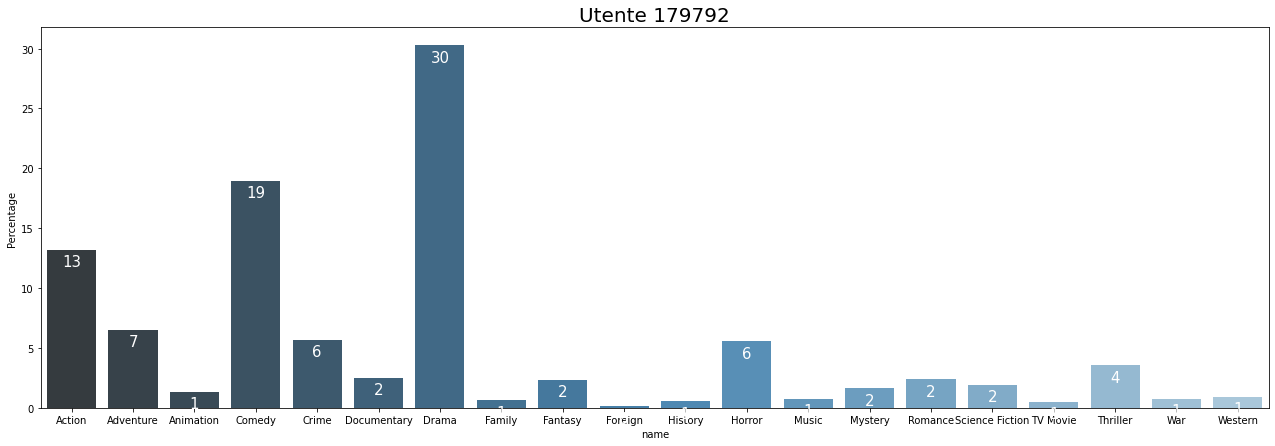

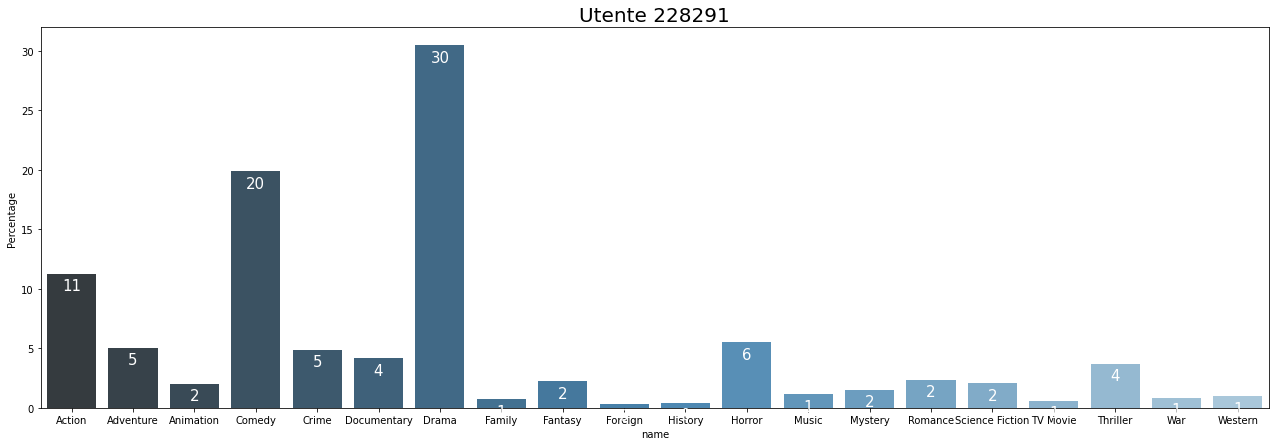

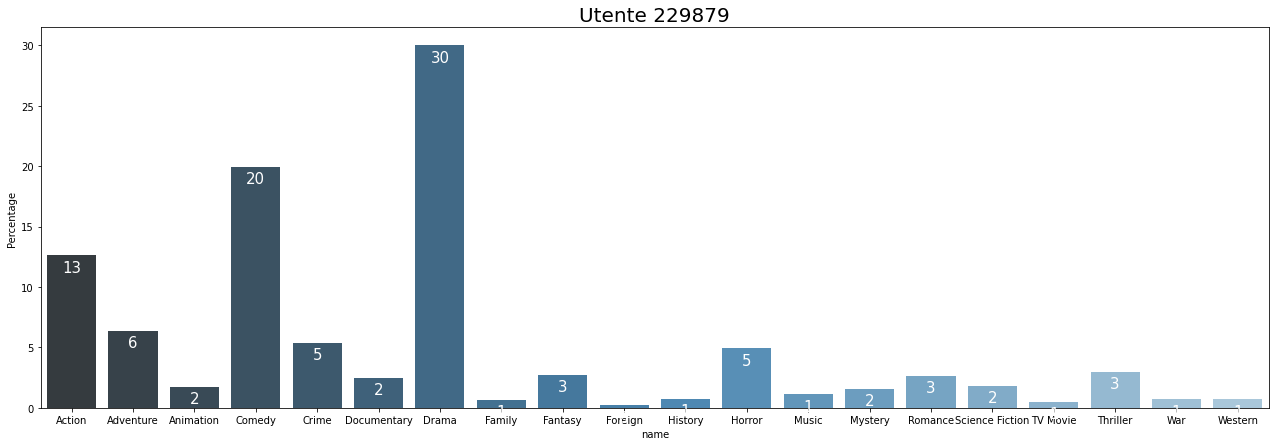

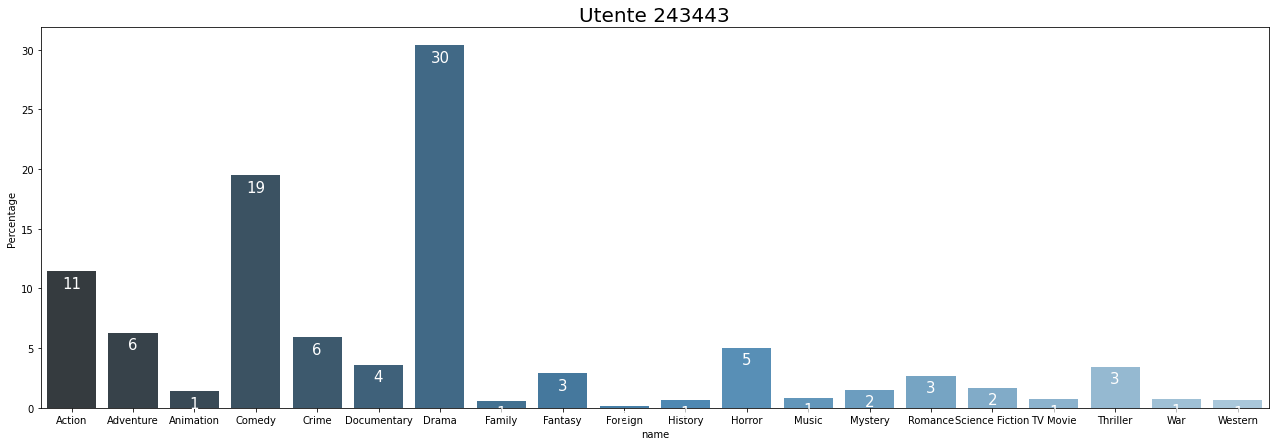

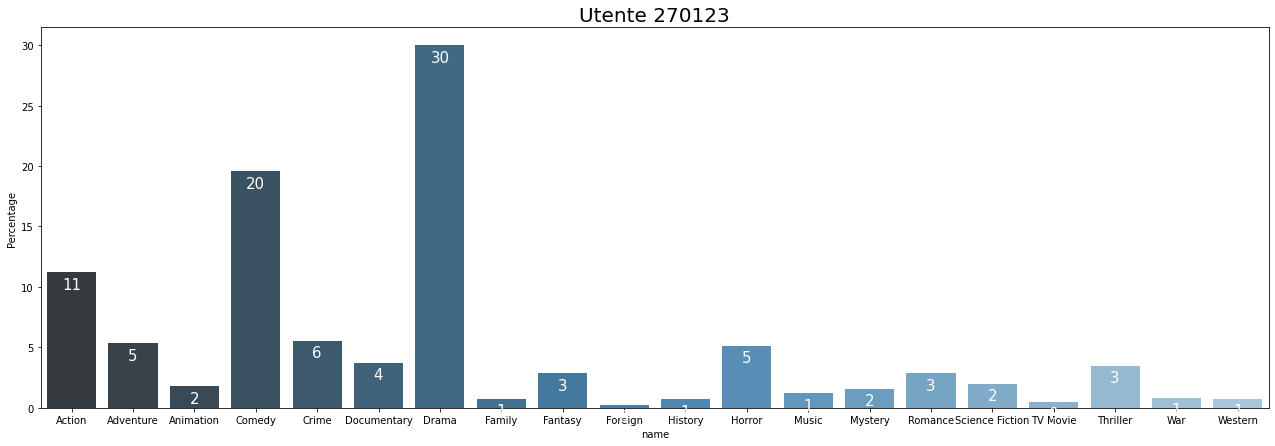

In [27]:
#FACCIO I GRAFICI
for p in range(len(s)):
    df_t=df_H[df_H['userId'] == s[p]]
    fig = plt.figure(figsize=(22,7))
    splot = sns.barplot(y="Percentage", x="name",data = df_t, palette="Blues_d")
 
    plt.title(f'Utente {s[p]}',fontsize=20)
    for p in splot.patches:
             splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=15, color = 'white',
                   xytext = (0, -12), 
                   textcoords = 'offset points')

In [28]:
#SEMBRA CHE VI SIA UNA PREVALENZA DI UN GENERE NEGLI UTENTI SELEZIONATI(IN QUESTO CASO DRAMA)